In [1]:
# Imports 
import os
import sys
sys.path.append("..")
os.environ["pyna_language"] = 'python'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
%matplotlib inline
from pyNA.pyna import pyna
from scipy.interpolate import RegularGridInterpolator

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [458]:
# Plot noise 
def plot_bar_chart(ac_name, epnl, limits, epnl_approach): 
    hatch = ['', '//']

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    colors = ['grey', 'tab:orange', 'tab:purple', 'tab:red']
    
    fig, ax = plt.subplots(1,1, figsize=(15,4))
    plt.style.use('../utils/plot.mplstyle')

    for i, case in enumerate(case_lst):

        bar_l = ax.bar(np.linspace(-0.3, +0.3, 4)+0+0.09*i-0.04, epnl[case]['lateral']-limits['lateral'], width=0.08, color=colors, hatch=hatch[i])
        bar_f = ax.bar(np.linspace(-0.3, +0.3, 4)+1+0.09*i-0.04, epnl[case]['flyover']-limits['flyover'], width=0.08, color=colors, hatch=hatch[i])
        bar_t = ax.bar(np.linspace(-0.3, +0.3, 4)+2+0.09*i-0.04, (epnl[case]['takeoff']+epnl_approach)-limits['cumulative'], width=0.08, color=colors, hatch=hatch[i])
        ax.set_xticks(np.arange(3))
        ax.set_xticklabels(['Lateral', 'Flyover', 'Cumulative'])
        ax.set_ylabel('$\Delta EPNL_{chapter\ 14}$\n[EPNdB]')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.plot([-0.5, 2.5], [0,0], 'k', linewidth=1)
        ax.set_xlim([-0.5, 2.5])
        
        if ac_name == 'stca':
            cb_alt = 260
            ax.set_ylim([-9,18.])
            ax.set_yticks(np.arange(-9, 18.1, 3))
        elif ac_name == 'a10':
            cb_alt = 210
            ax.set_ylim([-6, 19.])
            ax.set_yticks(np.arange(-6, 18.1, 3))

        if i == 0:
            ax.fill_between([18,19], [8,8], [9,9], color='grey', label='STCB ($z_{cb} \geq$'+str(cb_alt)+'m)', hatch=hatch[i])
            ax.fill_between([18,19], [8,8], [9,9], color='tab:orange', label='STCB ($z_{cb} <$'+str(cb_alt)+'m)', hatch=hatch[i])
            ax.fill_between([18,19], [8,8], [9,9], color='tab:purple', label='PTCB', hatch=hatch[i])
#             ax.fill_between([18,19], [8,8], [9,9], color='tab:red', label='PHLD', hatch=hatch[i])

    ax.annotate("", xy=(1.55, 7.2), xycoords='data', xytext=(1.55, -0.2), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=16)
    ax.plot([1.3, 2.5], [7, 7], 'k-', linewidth=1)
    ax.annotate(s="Chapter 4", xy=(1.3, 7.7), fontsize=16)

    if ac_name == 'a10':
        ax.plot([1.3, 2.5], [17, 17], 'k-', linewidth=1)
        ax.annotate(s="Chapter 3", xy=(1.3, 17.7), fontsize=16)
        ax.annotate("", xy=(1.47, 6.5), xycoords='data', xytext=(1.47, -0.2), textcoords='data', arrowprops=dict(arrowstyle="-", connectionstyle="arc3"), fontsize=16)
        ax.annotate("", xy=(1.47, 17.2), xycoords='data', xytext=(1.47, 10.), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=16)
        
    ax2 = ax.twinx()
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_xticks([-0.1, 0.9, 1.9])
    ax2.set_xticklabels(['Lateral', 'Flyover', 'Cumulative'])
    ax2.set_yticks([])
    ax2.fill_between([18,19], [8,8], [9,9], facecolor='w', edgecolor="k", label='$V_{max}$ = $V_2$ + 20 kts', hatch='')
    ax2.fill_between([18,19], [8,8], [9,9], facecolor='w', edgecolor="k", label='$V_{max}$ = 250 kts', hatch='//')

    ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.39), ncol=1, borderaxespad=0, frameon=False)
    ax2.legend(loc='lower left', bbox_to_anchor=(1.0, -0.05), ncol=1, borderaxespad=0, frameon=False)

In [439]:
# Inputs 
ac_lst = ['stca', 'a10']
case_lst = ['V2', 'Vmax']
trajectory_lst = ['stcb_base', 'stcb_adv', 'ptcb', 'phld']

z_cb_lst = np.hstack((np.linspace(25, 250, 10), np.linspace(300, 750, 10)))

TS_cb_lst = dict()
TS_cb_lst['stca']= dict()
TS_cb_lst['stca']['V2'] = np.linspace(0.75, 1.0, 11)
TS_cb_lst['stca']['Vmax'] = np.linspace(0.4, 1.0, 25)
TS_cb_lst['a10'] = dict()
TS_cb_lst['a10']['V2'] = np.linspace(0.775, 1.0, 10)
TS_cb_lst['a10']['Vmax'] = np.linspace(0.675, 1.0, 14)

Vmax_lst = dict()
Vmax_lst['stca'] = dict()
Vmax_lst['stca']['V2'] = 197*0.51444444
Vmax_lst['stca']['Vmax'] = 250*0.51444444
Vmax_lst['a10'] = dict()
Vmax_lst['a10']['V2'] = 234.4*0.51444444
Vmax_lst['a10']['Vmax'] = 250*0.51444444


In [440]:
# Load 
stcb_sweeps = dict()
ptcb_sweeps = dict()
idx_stcb_control = dict()
stcb_control = dict()
traj = dict()
epnl = dict()

for ac_name in ac_lst:
    
    stcb_sweeps[ac_name] = dict()
    ptcb_sweeps[ac_name] = dict()
    idx_stcb_control[ac_name] = dict()
    stcb_control[ac_name] = dict()
    traj[ac_name] = dict()
    epnl[ac_name] = dict()
    
    for case in case_lst:

        # Start of sideline noise 
        if ac_name == 'stca' and case == 'V2':
            start = 28
        elif ac_name == 'stca' and case == 'Vmax':
            start = 46
        elif ac_name == 'a10' and case == 'V2':
            start = 64
        elif ac_name == 'a10' and case == 'Vmax':
            start = 76
                        
        # Load STCB sweeps
        stcb_sweeps[ac_name][case] = dict()

        stcb_sweeps[ac_name][case]['sideline'] = np.load('../cases/'+ac_name+'/output/STCB/' + case + '/sweeps/epnl_sideline.npy') 
        stcb_sweeps[ac_name][case]['flyover']  = np.load('../cases/'+ac_name+'/output/STCB/' + case + '/sweeps/epnl_flyover.npy')     
        stcb_sweeps[ac_name][case]['lateral']  = np.max(stcb_sweeps[ac_name][case]['sideline'][:,:,start:], axis=2)
        stcb_sweeps[ac_name][case]['takeoff']  = stcb_sweeps[ac_name][case]['lateral'] + stcb_sweeps[ac_name][case]['flyover'] 

        # Load PTCB sweeps
        ptcb_sweeps[ac_name][case] = dict()
        if ac_name == 'stca' or ac_name == 'a10':
            ptcb_sweeps[ac_name][case]['sideline'] = np.load('../cases/'+ac_name+'/output/PTCB/' + case + '/epnl_sideline.npy') 
            ptcb_sweeps[ac_name][case]['flyover']  = np.load('../cases/'+ac_name+'/output/PTCB/' + case + '/epnl_flyover.npy') 
            ptcb_sweeps[ac_name][case]['lateral']  = np.max(ptcb_sweeps[ac_name][case]['sideline'][20:])
            ptcb_sweeps[ac_name][case]['takeoff']  = ptcb_sweeps[ac_name][case]['lateral'] + ptcb_sweeps[ac_name][case]['flyover']

        # Get index of key STCB controls
        idx_stcb_control[ac_name][case] = dict()
        epnl_sub = np.copy(stcb_sweeps[ac_name][case]['takeoff'])
        epnl_sub[:10, :] = 1000*np.ones((10, epnl_sub.shape[1]))
        idx_stcb_control[ac_name][case]['std'] = np.unravel_index(np.argmin(epnl_sub, axis=None), epnl_sub.shape)
        epnl_sub = stcb_sweeps[ac_name][case]['takeoff'][:10, :]
        idx_stcb_control[ac_name][case]['adv'] = np.unravel_index(np.argmin(epnl_sub, axis=None), epnl_sub.shape)

        # Get key STCB controls
        stcb_control[ac_name][case] = dict()
        stcb_control[ac_name][case]['z_cb'] = dict()
        stcb_control[ac_name][case]['TS_cb'] = dict()
        stcb_control[ac_name][case]['z_cb']['std'] = z_cb_lst[idx_stcb_control[ac_name][case]['std'][0]]
        stcb_control[ac_name][case]['z_cb']['adv'] = z_cb_lst[idx_stcb_control[ac_name][case]['adv'][0]]
        stcb_control[ac_name][case]['TS_cb']['std'] = TS_cb_lst[ac_name][case][idx_stcb_control[ac_name][case]['std'][1]]
        stcb_control[ac_name][case]['TS_cb']['adv'] = TS_cb_lst[ac_name][case][idx_stcb_control[ac_name][case]['adv'][1]]
        
        # Get epnl
        epnl[ac_name][case] = dict()
        epnl[ac_name][case]['lateral'] = np.zeros(4)
        epnl[ac_name][case]['flyover'] = np.zeros(4)
        epnl[ac_name][case]['takeoff'] = np.zeros(4)
        epnl[ac_name][case]['lateral'][0] = stcb_sweeps[ac_name][case]['lateral'][idx_stcb_control[ac_name][case]['std']]
        epnl[ac_name][case]['flyover'][0] = stcb_sweeps[ac_name][case]['flyover'][idx_stcb_control[ac_name][case]['std']]
        epnl[ac_name][case]['takeoff'][0] = stcb_sweeps[ac_name][case]['takeoff'][idx_stcb_control[ac_name][case]['std']]
        epnl[ac_name][case]['lateral'][1] = stcb_sweeps[ac_name][case]['lateral'][idx_stcb_control[ac_name][case]['adv']]
        epnl[ac_name][case]['flyover'][1] = stcb_sweeps[ac_name][case]['flyover'][idx_stcb_control[ac_name][case]['adv']]
        epnl[ac_name][case]['takeoff'][1] = stcb_sweeps[ac_name][case]['takeoff'][idx_stcb_control[ac_name][case]['adv']]
        
        if ac_name == 'stca' or ac_name == 'a10':
            epnl[ac_name][case]['lateral'][2] = ptcb_sweeps[ac_name][case]['lateral']
            epnl[ac_name][case]['flyover'][2] = ptcb_sweeps[ac_name][case]['flyover']
            epnl[ac_name][case]['takeoff'][2] = ptcb_sweeps[ac_name][case]['takeoff']
        else:
            epnl[ac_name][case]['lateral'][2] = np.nan
            epnl[ac_name][case]['flyover'][2] = np.nan
            epnl[ac_name][case]['takeoff'][2] = np.nan
        
        epnl[ac_name][case]['lateral'][3] = np.nan
        epnl[ac_name][case]['flyover'][3] = np.nan
        epnl[ac_name][case]['takeoff'][3] = np.nan
        
        epnl[ac_name][case]['sideline'] = dict()
        epnl[ac_name][case]['sideline']['std'] = stcb_sweeps[ac_name][case]['sideline'][idx_stcb_control[ac_name][case]['std']]
        epnl[ac_name][case]['sideline']['adv'] = stcb_sweeps[ac_name][case]['sideline'][idx_stcb_control[ac_name][case]['adv']]
        
        if ac_name == 'stca' or ac_name == 'a10':
            epnl[ac_name][case]['sideline']['ptcb'] = np.load('../cases/'+ac_name+'/output/PTCB/' + case + '/epnl_sideline.npy') 
        
        # Get trajectories
        traj[ac_name][case] = dict()
        traj[ac_name][case]['std'] = pd.read_csv('../cases/'+ac_name+'/trajectory/STCB/'+case+'/trajectory_'+ac_name+'_'+str(stcb_control[ac_name][case]['z_cb']['std'])+'_'+str(np.round(stcb_control[ac_name][case]['TS_cb']['std'], 3))+'.csv')
        traj[ac_name][case]['adv'] = pd.read_csv('../cases/'+ac_name+'/trajectory/STCB/'+case+'/trajectory_'+ac_name+'_'+str(stcb_control[ac_name][case]['z_cb']['adv'])+'_'+str(np.round(stcb_control[ac_name][case]['TS_cb']['adv'], 3))+'.csv')

        if ac_name == 'stca' or ac_name == 'a10':
            traj[ac_name][case]['ptcb'] = pd.read_csv('../cases/'+ac_name+'/trajectory/PTCB/'+case+'/trajectory_'+ac_name+'_ptcb_'+case+'.csv')

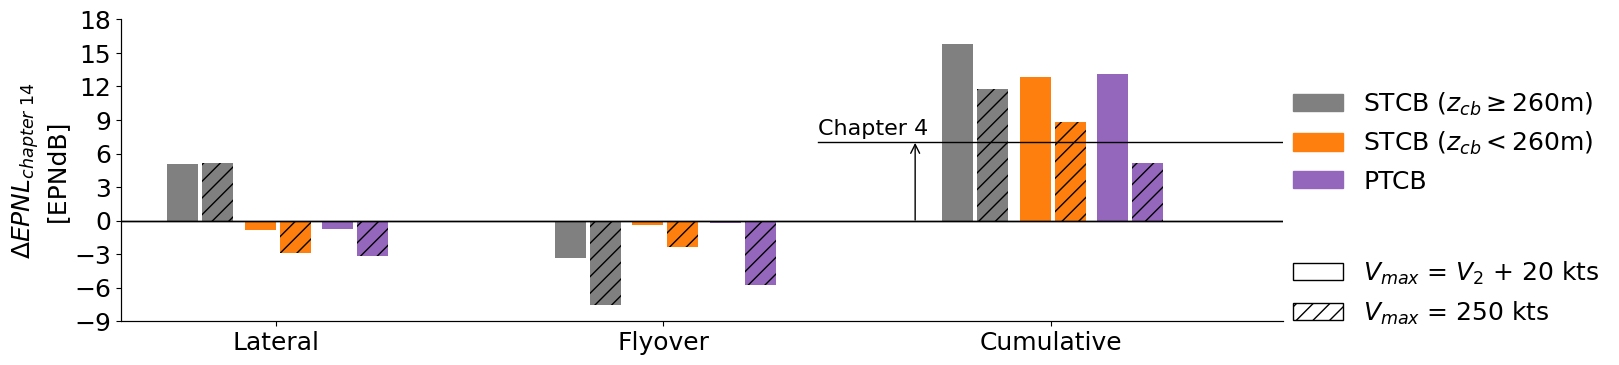

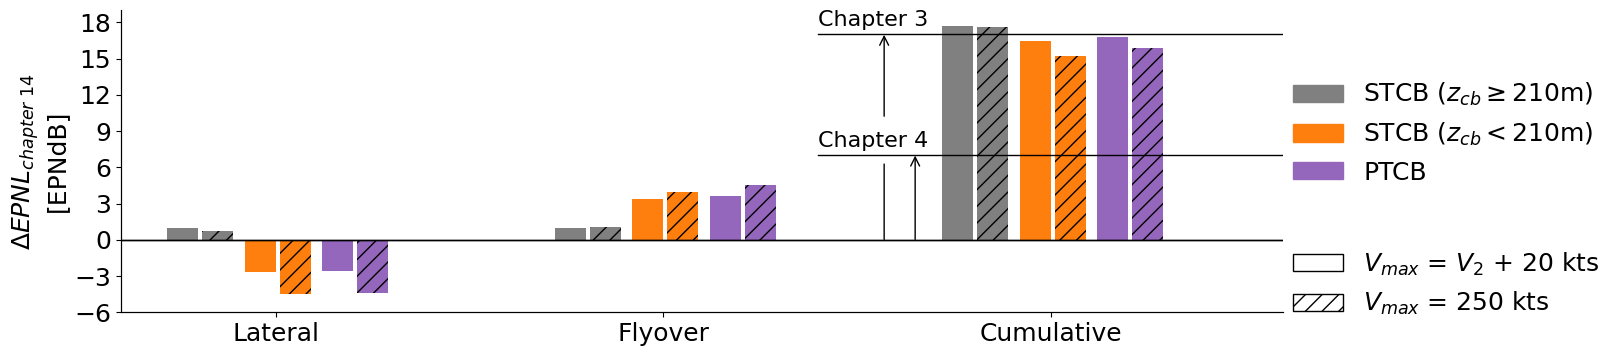

In [459]:
limits_stca = pyna.get_icao_annex_16_noise_limits(mtow=np.array([55.]), chapter='14', n_eng=3)
plot_bar_chart('stca', epnl['stca'], limits_stca, epnl_approach=98.6)

limits_a10 = pyna.get_icao_annex_16_noise_limits(mtow=np.array([166.5]), chapter='14', n_eng=3)
plot_bar_chart('a10', epnl['a10'], limits_a10, epnl_approach=104.)

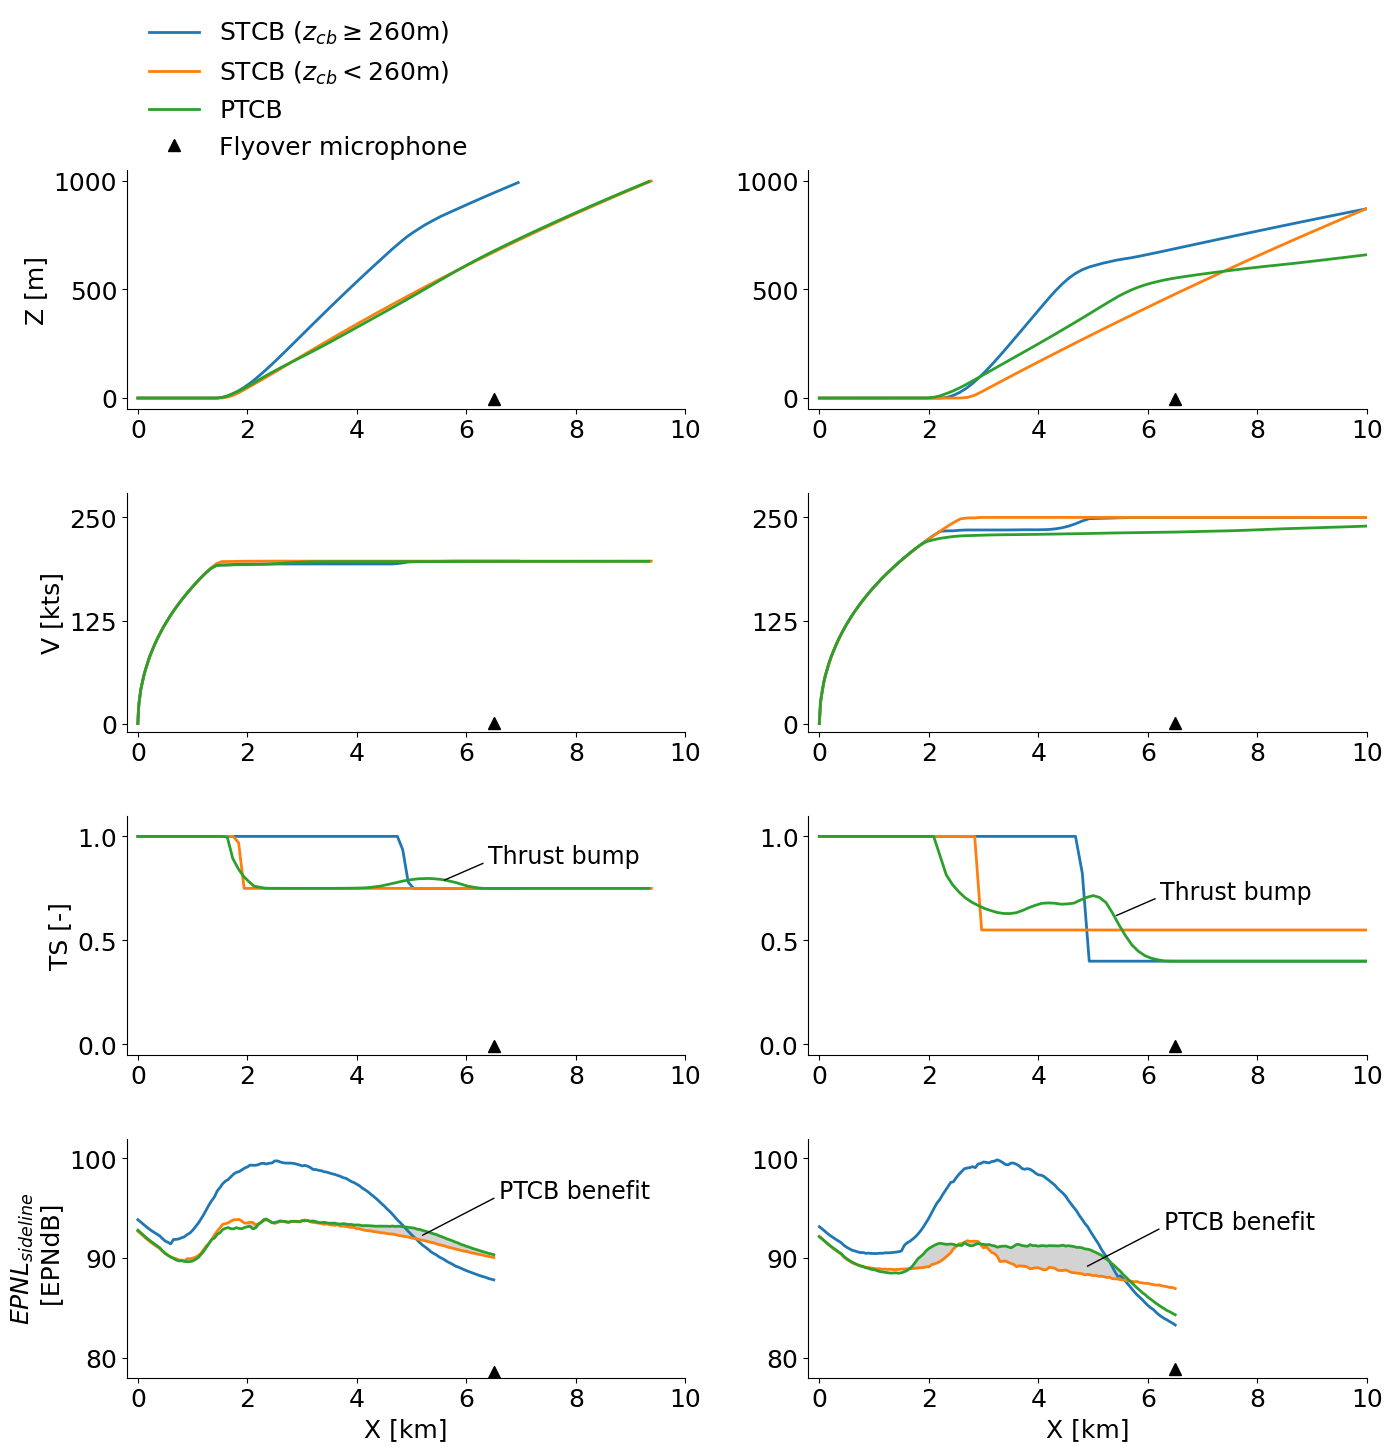

In [444]:
# Compare trajectories 
fig, ax = plt.subplots(4,2, figsize=(16, 16))
plt.style.use('../utils/plot.mplstyle')
color_lst = ['tab:blue', 'tab:orange', 'tab:green']
linestyle_lst = ['-', '-']

V2_lst = dict()
V2_lst['stca'] = 177
V2_lst['a10'] = 213.4

x_iter = np.linspace(0, 6500, 131)

ac_name = 'stca'
for j,case in enumerate(['V2', 'Vmax']):
    for i,traj_name in enumerate(traj[ac_name][case].keys()):

        idx = np.where(traj[ac_name][case][traj_name]['Z [m]'] <= 1000)[0]
        
        # Labels for trajectories
        if ac_name == 'stca':
            label = ['STCB ($z_{cb}\geq 260$m)', 'STCB ($z_{cb}<260$m)', 'PTCB', 'PHLD']
        elif ac_name == 'a10':
            label = ['STCB ($z_{cb}\geq 210$m)', 'STCB ($z_{cb}<210$m)', 'PTCB', 'PHLD']
             
        # Plot trajectories
        if case == 'V2':
            ax[0, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['Z [m]'][idx], color=color_lst[i], linestyle=linestyle_lst[j], label=label[i])
            ax[1, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['V [m/s]'][idx]/0.51444, color=color_lst[i], linestyle=linestyle_lst[j])    
            ax[2, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['TS [-]'][idx], color=color_lst[i], linestyle=linestyle_lst[j])    
            ax[3, j].plot(np.linspace(0, 6500, 131)/1000, epnl[ac_name][case]['sideline'][traj_name], color=color_lst[i], linestyle=linestyle_lst[j])    
            
        elif case == 'Vmax':
            ax[0, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['Z [m]'][idx], color=color_lst[i], linestyle=linestyle_lst[j])
            ax[1, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['V [m/s]'][idx]/0.51444, color=color_lst[i], linestyle=linestyle_lst[j])
            ax[2, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['TS [-]'][idx], color=color_lst[i], linestyle=linestyle_lst[j])
            ax[3, j].plot(np.linspace(0, 6500, 131)/1000, epnl[ac_name][case]['sideline'][traj_name], color=color_lst[i], linestyle=linestyle_lst[j])    
       
    # 
    if ac_name == 'stca':
        ax[0,j].set_ylim([-50, 1050])
        ax[3,j].set_ylim([78, 102])
#         ax[3,0].annotate(xy=(0, 81), s='EPNL\nILL-DEFINED', fontsize=16, color='k')
#         ax[3,1].annotate(xy=(0, 81), s='EPNL\nILL-DEFINED', fontsize=16, color='k')
        
        if  case == 'V2':
            start = 28
        elif  case == 'Vmax':
            start = 46
#         ax[3,j].fill_between([-1.000, x_iter[start]/1000.], [80, 80], [105, 105], color='grey', alpha=0.2, hatch='//')        
                
    elif ac_name == 'a10':    
        ax[0,j].set_ylim([-50, 750])
        ax[3,j].set_ylim([78, 102])
#         ax[3,j].annotate(xy=(0, 88), s='EPNL\nILL-DEFINED', fontsize=16, color='k')
#         ax[3,j].annotate(xy=(0, 88), s='EPNL\nILL-DEFINED', fontsize=16, color='k')
        
        if case == 'V2':
            start = 64
        elif case == 'Vmax':
            start = 76
#         ax[3,j].fill_between([-1.000, x_iter[start]/1000.], [80, 80], [105, 105], color='grey', alpha=0.2, hatch='//')
        
    ax[0,j].set_xlim([-0.200, 10.])
    ax[0,j].set_yticks([0.0, 500., 1000.])    
    ax[1,j].set_xlim([-0.200, 10.])
    ax[1,j].set_ylim([-10, 280])
    ax[1,j].set_yticks([0., 125., 250.])
    ax[2,j].set_xlim([-0.200, 10.])
    ax[2,j].set_ylim([-0.05, 1.1])
    ax[2,j].set_yticks([0.0, 0.5, 1.0])
    ax[3,j].set_xlim([-0.200, 10.])

ax[0,0].set_ylabel('Z [m]')
ax[1,0].set_ylabel('V [kts]')
ax[2,0].set_ylabel('TS [-]')
ax[3,0].set_ylabel('$EPNL_{sideline}$\n [EPNdB]')
ax[3,0].set_xlabel('X [km]')
ax[3,1].set_xlabel('X [km]')

ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['top'].set_visible(False)

ax[0,0].plot(6.5, -5, '^', markersize=8, color='k', label='Flyover microphone'); ax[0,1].plot(6.5, -5, '^', markersize=8, color='k')
ax[1,0].plot(6.5, 1, '^', markersize=8, color='k'); ax[1,1].plot(6.5, 1, '^', markersize=8, color='k')
ax[2,0].plot(6.5, -0.01, '^', markersize=8, color='k'); ax[2,1].plot(6.5, -0.01, '^', markersize=8, color='k')
ax[3,0].plot(6.5, 78.6, '^', markersize=8, color='k'); ax[3,1].plot(6.5, 78.9, '^', markersize=8, color='k')

ax[3, 0].fill_between(np.linspace(0, 6500, 131)[40:127]/1000, epnl[ac_name]['V2']['sideline']['adv'][40:127], epnl[ac_name]['V2']['sideline']['ptcb'][40:127], color='lightgrey', linestyle=linestyle_lst[j])    
ax[3, 1].fill_between(np.linspace(0, 6500, 131)[34:115]/1000, epnl[ac_name]['Vmax']['sideline']['adv'][34:115], epnl[ac_name]['Vmax']['sideline']['ptcb'][34:115], color='lightgrey', linestyle=linestyle_lst[j])    

ax[3,0].plot([5.2, 6.5], [92.3, 96], 'k-', linewidth=1)
ax[3,1].plot([4.9, 6.2], [89.2, 92.9], 'k-', linewidth=1)
ax[3,0].annotate(xy=(6.6, 96), s='PTCB benefit', fontsize=17)
ax[3,1].annotate(xy=(6.3, 92.9), s='PTCB benefit', fontsize=17)

ax[2,0].plot([5.6, 6.3], [0.79, 0.87], 'k-', linewidth=1)
ax[2,1].plot([5.43, 6.13], [0.62, 0.7], 'k-', linewidth=1)
ax[2,0].annotate(xy=(6.4, 0.87), s='Thrust bump', fontsize=17)
ax[2,1].annotate(xy=(6.23, 0.7), s='Thrust bump', fontsize=17)



ax[0,0].legend(loc='lower left', bbox_to_anchor=(0,0.95), frameon=False)
    
plt.subplots_adjust(hspace=0.35, wspace=0.22)

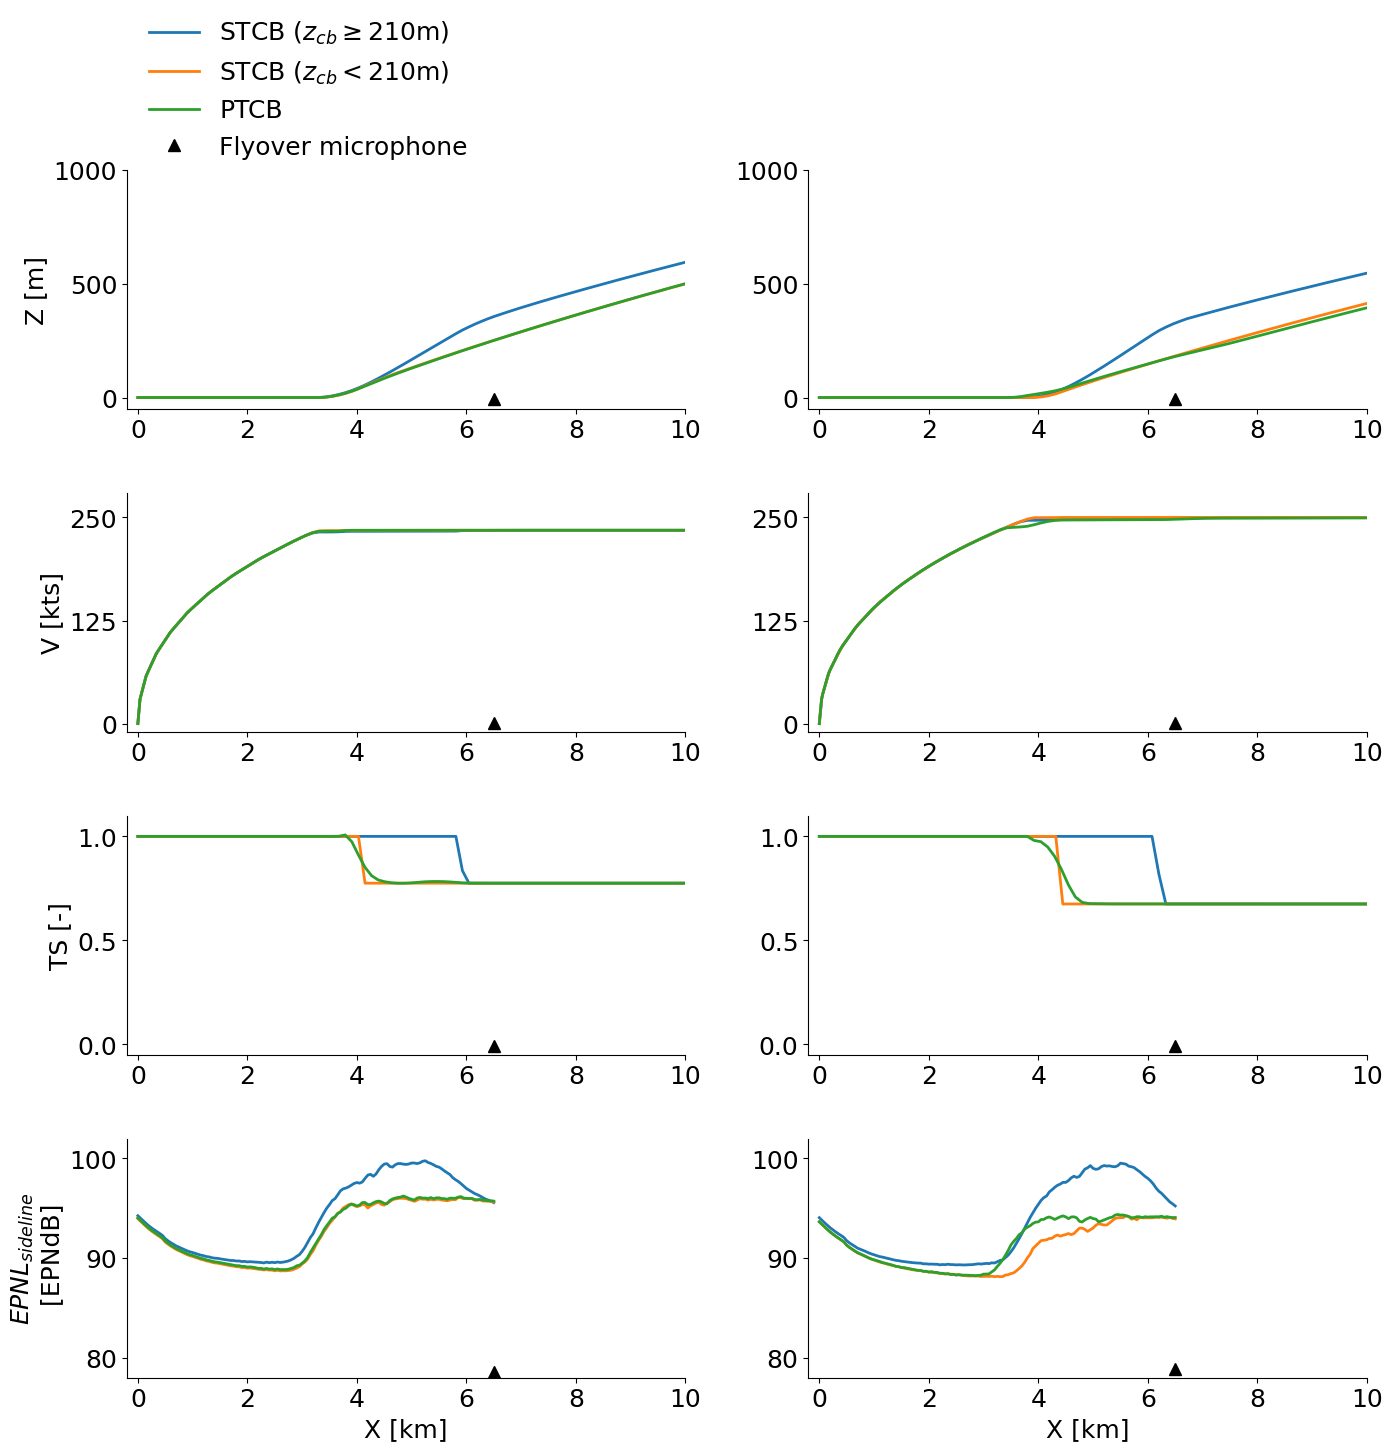

In [446]:
# Compare trajectories 
fig, ax = plt.subplots(4,2, figsize=(16, 16))
plt.style.use('../utils/plot.mplstyle')
color_lst = ['tab:blue', 'tab:orange', 'tab:green']
linestyle_lst = ['-', '-']

V2_lst = dict()
V2_lst['stca'] = 177
V2_lst['a10'] = 213.4

x_iter = np.linspace(0, 6500, 131)

ac_name = 'a10'
for j,case in enumerate(['V2', 'Vmax']):
    for i,traj_name in enumerate(traj[ac_name][case].keys()):

        idx = np.where(traj[ac_name][case][traj_name]['Z [m]'] <= 1000)[0]
        
        # Labels for trajectories
        if ac_name == 'stca':
            label = ['STCB ($z_{cb}\geq 260$m)', 'STCB ($z_{cb}<260$m)', 'PTCB', 'PHLD']
        elif ac_name == 'a10':
            label = ['STCB ($z_{cb}\geq 210$m)', 'STCB ($z_{cb}<210$m)', 'PTCB', 'PHLD']
             
        # Plot trajectories
        if case == 'V2':
            ax[0, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['Z [m]'][idx], color=color_lst[i], linestyle=linestyle_lst[j], label=label[i])
            ax[1, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['V [m/s]'][idx]/0.51444, color=color_lst[i], linestyle=linestyle_lst[j])    
            ax[2, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['TS [-]'][idx], color=color_lst[i], linestyle=linestyle_lst[j])    
            ax[3, j].plot(np.linspace(0, 6500, 131)/1000, epnl[ac_name][case]['sideline'][traj_name], color=color_lst[i], linestyle=linestyle_lst[j])    
            
        elif case == 'Vmax':
            ax[0, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['Z [m]'][idx], color=color_lst[i], linestyle=linestyle_lst[j])
            ax[1, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['V [m/s]'][idx]/0.51444, color=color_lst[i], linestyle=linestyle_lst[j])
            ax[2, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['TS [-]'][idx], color=color_lst[i], linestyle=linestyle_lst[j])
            ax[3, j].plot(np.linspace(0, 6500, 131)/1000, epnl[ac_name][case]['sideline'][traj_name], color=color_lst[i], linestyle=linestyle_lst[j])    
       
    # 
    if ac_name == 'stca':
        ax[0,j].set_ylim([-50, 1050])
        ax[3,j].set_ylim([78, 102])
#         ax[3,0].annotate(xy=(0, 81), s='EPNL\nILL-DEFINED', fontsize=16, color='k')
#         ax[3,1].annotate(xy=(0, 81), s='EPNL\nILL-DEFINED', fontsize=16, color='k')
        
        if  case == 'V2':
            start = 28
        elif  case == 'Vmax':
            start = 46
#         ax[3,j].fill_between([-1.000, x_iter[start]/1000.], [80, 80], [105, 105], color='grey', alpha=0.2, hatch='//')        
                
    elif ac_name == 'a10':    
        ax[0,j].set_ylim([-50, 750])
        ax[3,j].set_ylim([78, 102])
#         ax[3,j].annotate(xy=(0, 88), s='EPNL\nILL-DEFINED', fontsize=16, color='k')
#         ax[3,j].annotate(xy=(0, 88), s='EPNL\nILL-DEFINED', fontsize=16, color='k')
        
        if case == 'V2':
            start = 64
        elif case == 'Vmax':
            start = 76
#         ax[3,j].fill_between([-1.000, x_iter[start]/1000.], [80, 80], [105, 105], color='grey', alpha=0.2, hatch='//')
        
    ax[0,j].set_xlim([-0.200, 10.])
    ax[0,j].set_yticks([0.0, 500., 1000.])    
    ax[1,j].set_xlim([-0.200, 10.])
    ax[1,j].set_ylim([-10, 280])
    ax[1,j].set_yticks([0., 125., 250.])
    ax[2,j].set_xlim([-0.200, 10.])
    ax[2,j].set_ylim([-0.05, 1.1])
    ax[2,j].set_yticks([0.0, 0.5, 1.0])
    ax[3,j].set_xlim([-0.200, 10.])

ax[0,0].set_ylabel('Z [m]')
ax[1,0].set_ylabel('V [kts]')
ax[2,0].set_ylabel('TS [-]')
ax[3,0].set_ylabel('$EPNL_{sideline}$\n [EPNdB]')
ax[3,0].set_xlabel('X [km]')
ax[3,1].set_xlabel('X [km]')

ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['top'].set_visible(False)

ax[0,0].plot(6.5, -5, '^', markersize=8, color='k', label='Flyover microphone'); ax[0,1].plot(6.5, -5, '^', markersize=8, color='k')
ax[1,0].plot(6.5, 1, '^', markersize=8, color='k'); ax[1,1].plot(6.5, 1, '^', markersize=8, color='k')
ax[2,0].plot(6.5, -0.01, '^', markersize=8, color='k'); ax[2,1].plot(6.5, -0.01, '^', markersize=8, color='k')
ax[3,0].plot(6.5, 78.6, '^', markersize=8, color='k'); ax[3,1].plot(6.5, 78.9, '^', markersize=8, color='k')

# ax[3, 0].fill_between(np.linspace(0, 6500, 131)[40:127]/1000, epnl[ac_name]['V2']['sideline']['adv'][40:127], epnl[ac_name]['V2']['sideline']['ptcb'][40:127], color='lightgrey', linestyle=linestyle_lst[j])    
# ax[3, 1].fill_between(np.linspace(0, 6500, 131)[34:115]/1000, epnl[ac_name]['Vmax']['sideline']['adv'][34:115], epnl[ac_name]['Vmax']['sideline']['ptcb'][34:115], color='lightgrey', linestyle=linestyle_lst[j])    

# ax[3,0].plot([5.2, 6.5], [92.3, 96], 'k-', linewidth=1)
# ax[3,1].plot([4.9, 6.2], [89.2, 92.9], 'k-', linewidth=1)
# ax[3,0].annotate(xy=(6.6, 96), s='PTCB benefit', fontsize=17)
# ax[3,1].annotate(xy=(6.3, 92.9), s='PTCB benefit', fontsize=17)

# ax[2,0].plot([5.6, 6.3], [0.79, 0.87], 'k-', linewidth=1)
# ax[2,1].plot([5.43, 6.13], [0.62, 0.7], 'k-', linewidth=1)
# ax[2,0].annotate(xy=(6.4, 0.87), s='Thrust bump', fontsize=17)
# ax[2,1].annotate(xy=(6.23, 0.7), s='Thrust bump', fontsize=17)



ax[0,0].legend(loc='lower left', bbox_to_anchor=(0,0.95), frameon=False)
    
plt.subplots_adjust(hspace=0.35, wspace=0.22)

In [396]:
np.linspace(0, 6500, 131)

array([1700., 1750., 1800., 1850., 1900., 1950., 2000., 2050., 2100.,
       2150., 2200., 2250., 2300., 2350., 2400., 2450., 2500., 2550.,
       2600., 2650., 2700., 2750., 2800., 2850., 2900., 2950., 3000.,
       3050., 3100., 3150., 3200., 3250., 3300., 3350., 3400., 3450.,
       3500., 3550., 3600., 3650., 3700., 3750., 3800., 3850., 3900.,
       3950., 4000., 4050., 4100., 4150., 4200., 4250., 4300., 4350.,
       4400., 4450., 4500., 4550., 4600., 4650., 4700., 4750., 4800.,
       4850., 4900., 4950., 5000., 5050., 5100., 5150., 5200., 5250.,
       5300., 5350., 5400., 5450., 5500., 5550., 5600., 5650., 5700.])

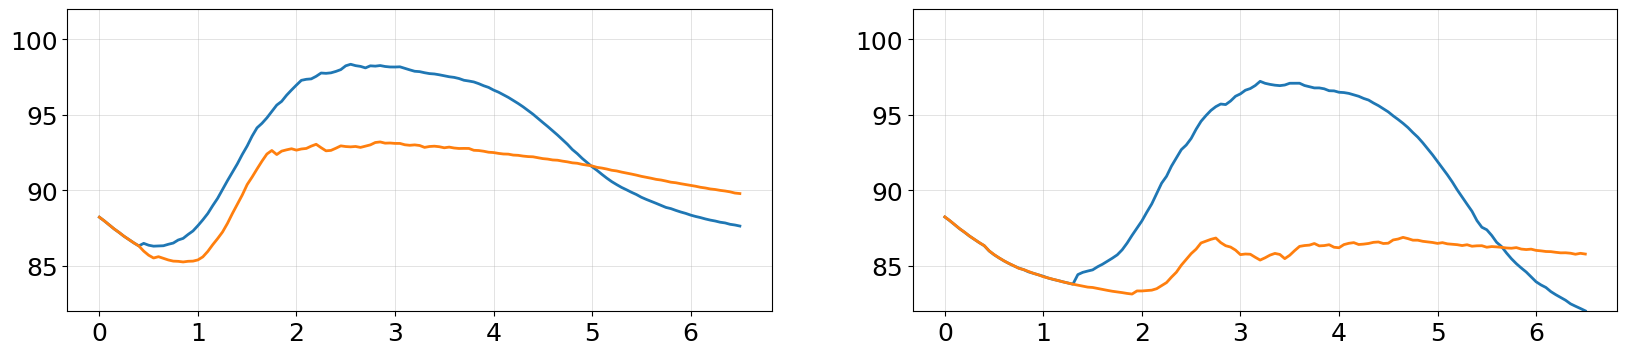

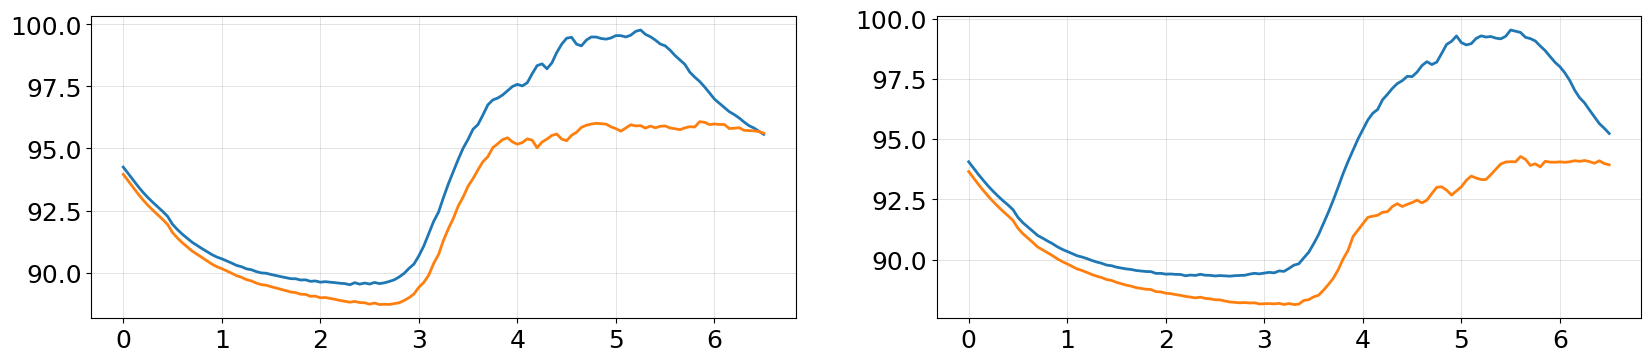

In [275]:
# Compare trajectories 
fig, ax = plt.subplots(1,2, figsize=(20, 4))


ax[0].plot(np.linspace(0, 6500, 131)/1000, epnl['stca']['V2']['sideline']['std'], color='tab:blue', linestyle=linestyle_lst[j])    
ax[0].plot(np.linspace(0, 6500, 131)/1000, epnl['stca']['V2']['sideline']['adv'], color='tab:orange', linestyle=linestyle_lst[j])    
ax[1].plot(np.linspace(0, 6500, 131)/1000, epnl['stca']['Vmax']['sideline']['std'], color='tab:blue', linestyle=linestyle_lst[j])    
ax[1].plot(np.linspace(0, 6500, 131)/1000, epnl['stca']['Vmax']['sideline']['adv'], color='tab:orange', linestyle=linestyle_lst[j])    
ax[0].set_ylim([82, 102])
ax[1].set_ylim([82, 102])


fig, ax = plt.subplots(1,2, figsize=(20, 4))
ax[0].plot(np.linspace(0, 6500, 131)/1000, epnl['a10']['V2']['sideline']['std'], color='tab:blue', linestyle=linestyle_lst[j])    
ax[0].plot(np.linspace(0, 6500, 131)/1000, epnl['a10']['V2']['sideline']['adv'], color='tab:orange', linestyle=linestyle_lst[j])    
ax[1].plot(np.linspace(0, 6500, 131)/1000, epnl['a10']['Vmax']['sideline']['std'], color='tab:blue', linestyle=linestyle_lst[j])    
ax[1].plot(np.linspace(0, 6500, 131)/1000, epnl['a10']['Vmax']['sideline']['adv'], color='tab:orange', linestyle=linestyle_lst[j])    



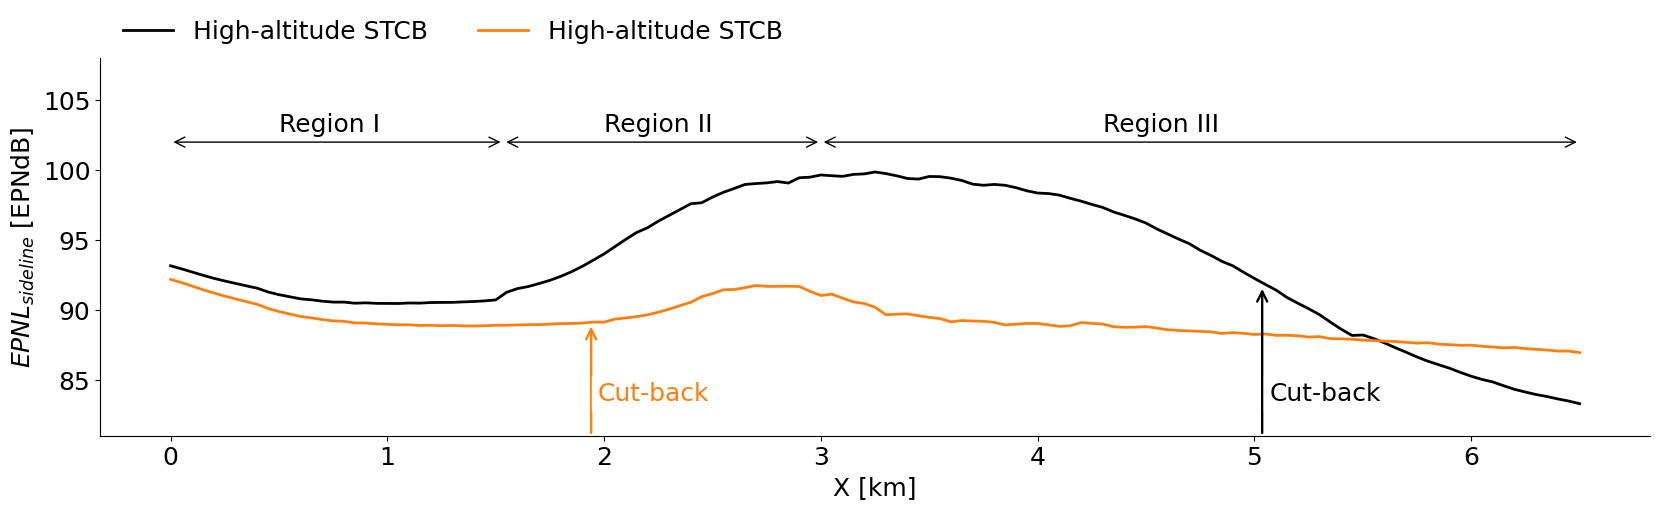

In [362]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(np.linspace(0, 6500, 131)/1000, epnl['stca']['Vmax']['sideline']['std'], color='k', label='High-altitude STCB')  
ax.plot(np.linspace(0, 6500, 131)/1000, epnl['stca']['Vmax']['sideline']['adv'], color='tab:orange', label='High-altitude STCB')    
ax.set_ylim([81, 108])
ax.set_ylabel('$EPNL_{sideline}$ [EPNdB]')
ax.set_xlabel('X [km]')

x_liftoff = traj['stca']['V2']['std']['X [m]'][np.where(traj['stca']['V2']['std']['Z [m]']>0.1)[0][0]]/1000
# ax.plot([x_liftoff, x_liftoff], [81, 108], '-', color='k', linewidth=1)

x_cb = traj['stca']['V2']['std']['X [m]'][np.where(traj['stca']['V2']['std']['TS [-]']<0.78)[0][0]]/1000
ax.annotate("", xy=(x_cb, 81), xycoords='data', xytext=(x_cb, 91.7), textcoords='data', arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color='k', linewidth=1.7), fontsize=18)


x_cb = traj['stca']['V2']['adv']['X [m]'][np.where(traj['stca']['V2']['adv']['TS [-]']<0.78)[0][0]]/1000
ax.annotate("", xy=(x_cb, 81), xycoords='data', xytext=(x_cb, 89), textcoords='data', arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color='tab:orange', linewidth=1.7), fontsize=18, )


ax.annotate("", xy=(0, 102), xycoords='data', xytext=(x_liftoff, 102), textcoords='data', arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"), fontsize=18)
ax.annotate("", xy=(x_liftoff, 102), xycoords='data', xytext=(3, 102), textcoords='data', arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"), fontsize=18)
ax.annotate("", xy=(3, 102), xycoords='data', xytext=(6.5, 102), textcoords='data', arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"), fontsize=18)

ax.annotate(xy=(0.5, 102.8), s="Region I", fontsize=18)
ax.annotate(xy=(2.0, 102.8), s="Region II", fontsize=18)
ax.annotate(xy=(4.3, 102.8), s="Region III", fontsize=18)

# ax.annotate(xy=(1.1, 83.5), s='Lift-off', fontsize=18, backgroundcolor='w', color='k')
ax.annotate(xy=(5.07, 83.5), s='Cut-back', fontsize=18, backgroundcolor='w', color='k')
ax.annotate(xy=(1.97, 83.5), s='Cut-back', fontsize=18, backgroundcolor='w', color='tab:orange')

ax.grid(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.legend(loc='lower left', bbox_to_anchor=(0,0.98), frameon=False, ncol=2)



In [ ]:
color_lst = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
# linestyle_lst = ['-', '-']

# V2_lst = dict()
# V2_lst['stca'] = 177
# V2_lst['a10'] = 213.4

# x_iter = np.linspace(0, 6500, 131)

# ac_name = 'stca'
# for j,case in enumerate(['V2', 'Vmax']):
#     for i,traj_name in enumerate(traj[ac_name][case].keys()):

#         idx = np.where(traj[ac_name][case][traj_name]['Z [m]'] <= 1000)[0]
        
#         # Labels for trajectories
#         if ac_name == 'stca':
#             label = ['STCB ($z_{cb}\geq 260$m)', 'STCB ($z_{cb}<260$m)', 'PTCB', 'PHLD']
#         elif ac_name == 'a10':
#             label = ['STCB ($z_{cb}\geq 210$m)', 'STCB ($z_{cb}<210$m)', 'PTCB', 'PHLD']
             
#         # Plot trajectories
#         if case == 'V2':
#             ax[3, j].plot(np.linspace(0, 6500, 131)/1000, epnl[ac_name][case]['sideline'][traj_name], color=color_lst[i], linestyle=linestyle_lst[j])    
            
#         elif case == 'Vmax':
#             ax[3, j].plot(np.linspace(0, 6500, 131)/1000, epnl[ac_name][case]['sideline'][traj_name], color=color_lst[i], linestyle=linestyle_lst[j])    

# ax[3,0].set_ylabel('$EPNL_{sideline}$\n [EPNdB]')
# ax[3,0].set_xlabel('X [km]')
# ax[3,1].set_xlabel('X [km]')

# ax[0,0].plot(6.5, 45, '^', markersize=8, color='k', label='Flyover microphone'); ax[0,1].plot(6.5, 45, '^', markersize=8, color='k')
# ax[1,0].plot(6.5, 10, '^', markersize=8, color='k'); ax[1,1].plot(6.5, 10, '^', markersize=8, color='k')
# ax[2,0].plot(6.5, 0.04, '^', markersize=8, color='k'); ax[2,1].plot(6.5, 0.04, '^', markersize=8, color='k')
# ax[3,0].plot(6.5, 80.8, '^', markersize=8, color='k'); ax[3,1].plot(6.5, 80.8, '^', markersize=8, color='k')

# ax[0,0].legend(loc='lower left', bbox_to_anchor=(0,0.95), frameon=False)
    
# plt.subplots_adjust(hspace=0.35, wspace=0.22)

In [168]:
# Compute full thrust
F_n_interp = RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['F_n'])


F_n_full_v2   = F_n_interp(( np.maximum(np.ones(np.size(traj['v2']['ptcb']['Z [m]'].values)), traj['v2']['ptcb']['Z [m]'].values), traj['v2']['ptcb']['M_0 [-]'].values, np.ones(np.size(traj['v2']['ptcb']['Z [m]'].values))))
F_n_full_vmax = F_n_interp(( np.maximum(np.ones(np.size(traj['vmax']['ptcb']['Z [m]'].values)), traj['vmax']['ptcb']['Z [m]'].values), traj['vmax']['ptcb']['M_0 [-]'].values, np.ones(np.size(traj['vmax']['ptcb']['Z [m]'].values))))



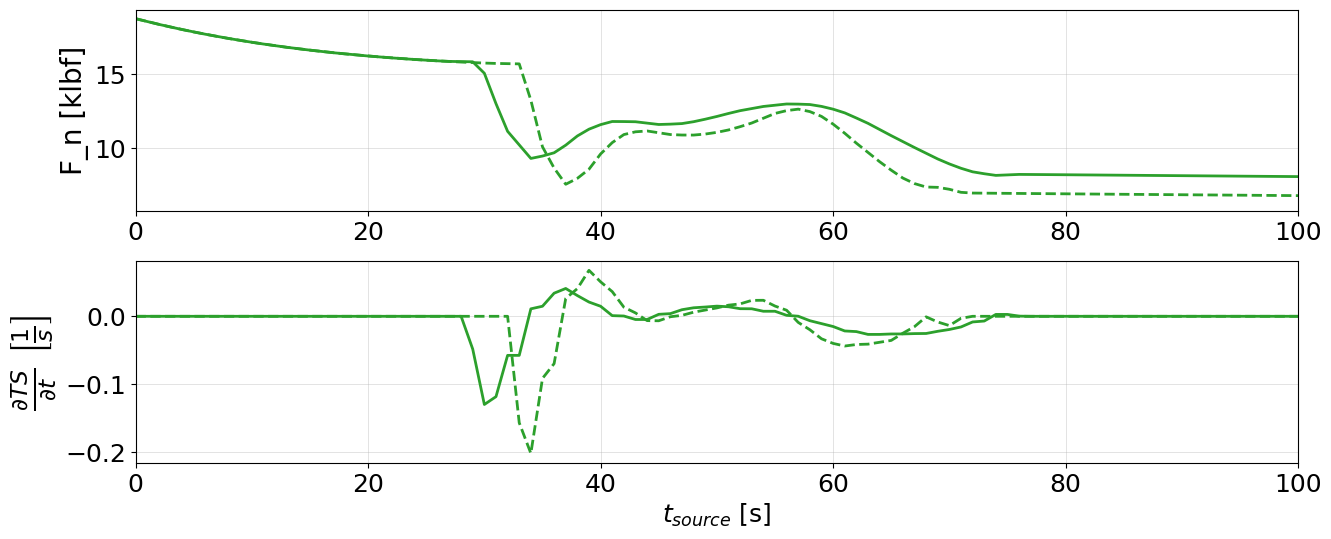

In [207]:
fig, ax = plt.subplots(2,1, figsize=(15,6))
plt.style.use('../utils/plot.mplstyle')



ax[0].plot(traj['v2']['ptcb']['t_source [s]'], traj['v2']['ptcb']['F_n [N]']/1000*0.224, '-', color='tab:green')
ax[0].plot(traj['vmax']['ptcb']['t_source [s]'], traj['vmax']['ptcb']['F_n [N]']/1000*0.224, '--', color='tab:green')
ax[0].set_xlim([0, 100])
# ax[0].set_ylim([0.4, 1.05])
ax[0].set_ylabel('F_n [klbf]', fontsize=20)

ax[1].plot(traj['v2']['ptcb']['t_source [s]'][:-1], np.diff(traj['v2']['ptcb']['TS [-]'])/np.diff(traj['v2']['ptcb']['t_source [s]']), '-', color='tab:green')
ax[1].plot(traj['vmax']['ptcb']['t_source [s]'][:-1], np.diff(traj['vmax']['ptcb']['TS [-]'])/np.diff(traj['vmax']['ptcb']['t_source [s]']), '--', color='tab:green')
ax[1].set_xlim([0, 100])

ax[1].set_xlabel('$t_{source}$ [s]')
ax[1].set_ylabel(r'$\frac{\partial TS}{\partial t}\ \left[\frac{1}{s}\right]$', fontsize=24)

plt.subplots_adjust(hspace=0.25)